In [1]:
import math
import numpy as np

import drawSvg as draw
from drawSvg import Drawing
from hyperbolic import euclid
from hyperbolic.poincare.shapes import *
from hyperbolic.poincare import Transform
from hyperbolic.poincare.util import (
    radialEuclidToPoincare, triangleSideForAngles)
import hyperbolic.tiles as htiles

In [2]:
# Control the orientation that tiles are placed together
class TileLayoutIsosceles(htiles.TileLayout):
    def calcGenIndex(self, code):
        ''' Controls which type of tile to place '''
        return 0
    def calcTileTouchSide(self, code, genIndex):
        ''' Controls tile orientation '''
        try:
            side, colors = code
            return 2 - side
        except TypeError:
            return 0
    def calcSideCodes(self, code, genIndex, touchSide, defaultCodes):
        ''' Controls tile side codes '''
        try:
            side, colors = code
            # 0=red, 1=orange, 2=yellow, 3=lime, 4=green, 5=blue, 6=pink
            if side != 1:
                if side == 0: shift = -1
                elif side == 2: shift = 1
                else: shift = 0
                nc = len(colors)
                newColors = [colors[(i+shift)%nc] for i in range(nc)]
            else:
                newColors = [colors[0], colors[1], colors[6], colors[4],
                    colors[3], colors[5], colors[2]]
        except TypeError:
            nc = q1
            newColors = [(i+code)%nc for i in range(nc)]
        return [(side, newColors) for side in range(3)]

In [3]:
q1 = 7  # Number of polygons around some points
q2 = 6  # Number of polygons around other points
depth = 10  # How far from the center to draw tiles

# Calculate isosceles triangle
assert q2 > 4 and q2 % 2 == 0, 'q2 must be even and at least 6'
phi1, phi2 = math.pi*2/q1, math.pi*2/q2
# Side lengths
s0 = triangleSideForAngles(phi1, phi2, phi2)
s1 = triangleSideForAngles(phi2, phi2, phi1)
s2 = s0
pt0 = Point.fromHPolar(0,0)
pt1 = Point.fromHPolar(s0,0)
pt2 = Point.fromHPolar(s2,phi1)
# Circumcircle
circumcirc = euclid.shapes.Circle.fromPoints(*pt0, *pt1, *pt2)
r = radialEuclidToPoincare(circumcirc.r)
ptCenter = Point.fromEuclid(circumcirc.cx, circumcirc.cy)
# Translate triangle to center
transCenter = Transform.shiftOrigin(ptCenter, pt0)
ptc0, ptc1, ptc2 = transCenter(pt0, pt1, pt2)
centerPoints = (ptc0, ptc1, ptc2)
tile = htiles.Tile(centerPoints)

In [4]:
# Calculate weave width
# For right triangle: tan(A) = tanh(opp) / sinh(adj)
# => opp = atanh(tan(A) * sinh(adj))
rInsc = math.atanh(math.tan(phi2/2) * math.sinh(s1/2))  # Inscribed circle radius
h = math.atanh(math.tan(phi2) * math.sinh(s1/2))  # Triangle height
centerDiff = r - (h - rInsc)

tGen = htiles.TileGen.fromCenterTile(tile)

decoratorLate = htiles.TileDecoratorLateInit()

tLayout = TileLayoutIsosceles()
tLayout.addGenerator(tGen, (0,)*4, decoratorLate)
startTile = tLayout.startTile(code=2,rotateDeg=0,centerCorner=False)

tiles = tLayout.tilePlane(startTile, depth=depth)

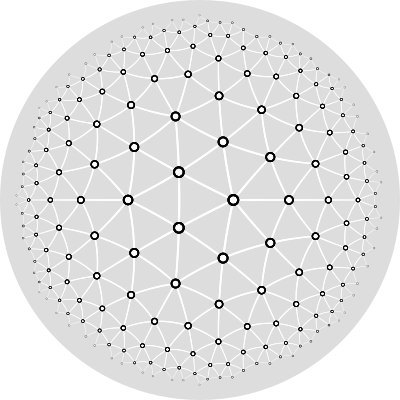

In [5]:
def drawTiles(drawing, tiles):
    for tile in tiles:
        tile.decorator = None
        d.draw(tile, hwidth=0.02, fill='white')
    for tile in tiles:
        d.draw(tile, drawVerts=True, hradius=0.05, hwidth=0.02,
                     fill='black', opacity=0.6)
        
d = draw.Drawing(2, 2, origin='center')
d.draw(euclid.shapes.Circle(0, 0, 1), fill='#ddd')
drawTiles(d, tiles)

d.setRenderSize(w=400)
d.saveSvg('images/isosceles-{}-{}.svg'.format(q1, q2))
d

In [6]:
# Draw a fancy weave pattern on each tile
class TileDecoratorWeaveColor(htiles.TileDecorator):
    colorMap = ['red', 'orange', 'yellow', 'lime', 'green', 'blue', 'pink', 'gray']
    def __init__(self, width, inset, drawExtra,
                 baseTile, tile3, tile6, tile8IfBackside=None):
        tile8, backside = tile8IfBackside, tile8IfBackside is not None
        self.backside = backside
        self.trans = baseTile.trans.inverted()
        trans3 = Transform.merge(self.trans, tile3.trans)
        trans6 = Transform.merge(self.trans, tile6.trans)
        p1, p2 = trans3((0,0), (0,0.5))
        p3, p4 = trans3(p1, p2)
        p5, p6 = trans6(p1, p2)
        p7, p8 = trans6(p3, p4)
        if backside:
            pMirror1, pMirror2 = baseTile.vertices[0], tile8.vertices[0]
            transMirror = Transform.mirror(pMirror1, pMirror2)
            p2, p1, p4, p3, p6, p5, p8, p7 = transMirror(p1, p2, p3, p4, p5, p6, p7, p8)
        lineMain = Line.fromPoints(*p1, *p2, segment=False)
        lineCover1 = Line.fromPoints(*p3, *p4, segment=False)
        lineCover2 = Line.fromPoints(*p5, *p6, segment=False)
        lineExtra2 = Line.fromPoints(*p7, *p8, segment=False)
        lineMain1 = lineMain.makeOffset(width/2)
        lineMain2 = lineMain.makeOffset(-width/2)
        lineMain2.reverse()
        lineExtra1 = lineCover2.makeOffset(width/2)
        lineCover1 = lineCover1.makeOffset(-width/2)
        lineCover2 = lineCover2.makeOffset(-width/2)
        lineExtra2 = lineExtra2.makeOffset(-width/2)
        if backside:
            edges = (lineCover2, lineMain2, lineCover1, lineMain1)
        else:
            edges = (lineCover1, lineMain2, lineCover2, lineMain1)
        poly = Polygon.fromEdges(edges,
                                 join=True)
        poly = poly.offsetPolygon(-inset)
        self.polyPoints = poly.makeRestorePoints()
        if drawExtra:
            if backside:
                edges2 = (lineMain2, lineExtra1, lineExtra2)
            else:
                edges2 = (lineMain2, lineExtra2, lineExtra1)
            poly2 = Polygon.fromEdges(edges2,
                                 join=True)
            poly2 = poly2.offsetPolygon(-inset)
            self.polyPoints2 = poly2.makeRestorePoints()
        else:
            self.polyPoints2 = None
    def toDrawables(self, elements, tile=None, **kwargs):
        trans = self.trans
        if tile is not None:
            trans = Transform.merge(trans, tile.trans)
            colorI = tile.sides[0].code[1][0]
        else:
            colorI = -1
        color = self.colorMap[colorI]
        polyPoints = trans.applyToList(self.polyPoints)
        poly = Polygon.fromRestorePoints(polyPoints)
        if self.polyPoints2 is not None:
            polyPoints2 = trans.applyToList(self.polyPoints2)
            poly2 = Polygon.fromRestorePoints(polyPoints2)
        else:
            poly2 = None
        ds = []
        ds.extend(poly.toDrawables(elements, fill=color, **kwargs))
        if poly2 is not None:
            ds.extend(poly2.toDrawables(elements, fill=color, **kwargs))
        return ds

In [7]:
# Find weave width and center
pa0 = tiles[49].vertices[0]
pa1 = tiles[0].vertices[0]
pa2 = tiles[38].vertices[0]
pb0 = tiles[8].vertices[0]
pb1 = tiles[5].vertices[0]
pb2 = tiles[127].vertices[0]
hyp1 = Hypercycle.fromPoints(*pa0, *pa1, *pa2, segment=False)
hyp2 = Hypercycle.fromPoints(*pb0, *pb1, *pb2, segment=False)
pm1 = hyp1.midpointEuclid()
pm2 = hyp2.midpointEuclid()
weaveWidthWide = pm1.distanceTo(pm2)
pmm = Transform.translation(pm2, pm1).applyToPoint(Point.fromHPolar(weaveWidthWide/2,0))
# Find thin width
pc0, pc1 = tiles[0].vertices[1:3]
line3 = Line.fromPoints(*pc0, *pc1, segment=False)
pm3 = line3.midpointEuclid()
weaveWidthThin = weaveWidthWide - 2*pm3.distanceTo(pm2)

In [8]:
# Translate all tiles to center
translate = Transform.shiftOrigin(pmm, pm1)
tiles = [tile.makeTransformed(translate) for tile in tiles]
baseTiles = tiles
baseTile = tiles[0]

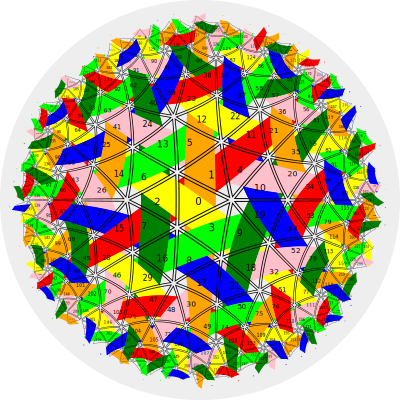

In [9]:
d = draw.Drawing(2, 2, origin='center')
d.draw(euclid.shapes.Circle(0, 0, 1), fill='#eee')

decorator = TileDecoratorWeaveColor(
                    weaveWidthThin*0.7, 0, True,
                    tiles[0], tiles[3], tiles[6])

for tile in tiles:
    tile.decorator = decorator
    d.draw(tile)#, fill='black')
decorateOutline = htiles.TileDecoratorOffset(0.01)
for tile in tiles:
    tile.decorator = decorateOutline
    d.draw(tile, hwidth=(0, 0.01))
decorateNums = htiles.TileDecoratorNumbered(size=0.1)
for tile in tiles:
    tile.decorator = decorateNums
    d.draw(tile)

d.setRenderSize(w=400)
d.saveSvg('images/isoscelesWeaveOutline.svg')
d